In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import math
from tqdm import tqdm

from PIL import Image, ImageOps

In [2]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
# DATA_DIR = "/Volumes/SSD970/"


## Axial boundary

In [3]:
xray_df = pd.read_csv(os.path.join(DATA_DIR, 'meta_xray.csv')).drop_duplicates(subset='UID').set_index('UID')
xray_df = xray_df["aspect"]
print(len(xray_df))
xray_df.head()

2011


UID
1.2.826.0.1.3680043.10001    2.461541
1.2.826.0.1.3680043.10005    2.091504
1.2.826.0.1.3680043.10014    3.418803
1.2.826.0.1.3680043.10016    1.136566
1.2.826.0.1.3680043.10032    1.951216
Name: aspect, dtype: float64

In [4]:
sagittal_df = pd.read_csv(os.path.join(DATA_DIR, 'infer_sagittal_boundary.csv')).set_index('UID')
sagittal_df = sagittal_df[['xmin','xmax']]
sagittal_df = sagittal_df.add_prefix('sagittal_')
print(len(sagittal_df))
sagittal_df.tail()

2012


,sagittal_xmin,sagittal_xmax
UID,,
1.2.826.0.1.3680043.9926,81.474365,330.13700
1.2.826.0.1.3680043.9940,43.931564,433.26350
1.2.826.0.1.3680043.9994,132.359540,419.59164
1.2.826.0.1.3680043.9996,11.594978,377.10385
1.2.826.0.1.3680043.9997,6.481827,415.57568


In [5]:
coronal_df = pd.read_csv(os.path.join(DATA_DIR, 'infer_coronal_boundary.csv')).set_index('UID')
coronal_df = coronal_df[['xmin','xmax']]
coronal_df = coronal_df.add_prefix('coronal_')
print(len(coronal_df))
coronal_df.tail()

2012


,coronal_xmin,coronal_xmax
UID,,
1.2.826.0.1.3680043.9926,103.523580,379.67520
1.2.826.0.1.3680043.9940,68.295395,476.78656
1.2.826.0.1.3680043.9994,144.880840,375.04407
1.2.826.0.1.3680043.9996,103.145035,406.66434
1.2.826.0.1.3680043.9997,52.653015,453.41766


In [6]:
boundary_df = pd.concat((sagittal_df, coronal_df, xray_df), axis=1)
print(len(boundary_df))
boundary_df.tail()

2012


,sagittal_xmin,sagittal_xmax,coronal_xmin,coronal_xmax,aspect
UID,,,,,
1.2.826.0.1.3680043.9926,81.474365,330.13700,103.523580,379.67520,2.844444
1.2.826.0.1.3680043.9940,43.931564,433.26350,68.295395,476.78656,2.666667
1.2.826.0.1.3680043.9994,132.359540,419.59164,144.880840,375.04407,1.886792
1.2.826.0.1.3680043.9996,11.594978,377.10385,103.145035,406.66434,1.916167
1.2.826.0.1.3680043.9997,6.481827,415.57568,52.653015,453.41766,2.782613


In [7]:
boundary_df["xmin"] = boundary_df["coronal_xmin"].clip(lower=0)
boundary_df["ymin"] = boundary_df["sagittal_xmin"].clip(lower=0)
boundary_df["xmax"] = boundary_df["coronal_xmax"].clip(upper=512)
boundary_df["ymax"] = boundary_df["sagittal_xmax"].clip(upper=512)
print(len(boundary_df))
boundary_df.tail()

2012


,sagittal_xmin,sagittal_xmax,coronal_xmin,coronal_xmax,aspect,xmin,ymin,xmax,ymax
UID,,,,,,,,,
1.2.826.0.1.3680043.9926,81.474365,330.13700,103.523580,379.67520,2.844444,103.523580,81.474365,379.67520,330.13700
1.2.826.0.1.3680043.9940,43.931564,433.26350,68.295395,476.78656,2.666667,68.295395,43.931564,476.78656,433.26350
1.2.826.0.1.3680043.9994,132.359540,419.59164,144.880840,375.04407,1.886792,144.880840,132.359540,375.04407,419.59164
1.2.826.0.1.3680043.9996,11.594978,377.10385,103.145035,406.66434,1.916167,103.145035,11.594978,406.66434,377.10385
1.2.826.0.1.3680043.9997,6.481827,415.57568,52.653015,453.41766,2.782613,52.653015,6.481827,453.41766,415.57568


1.2.826.0.1.3680043.10136


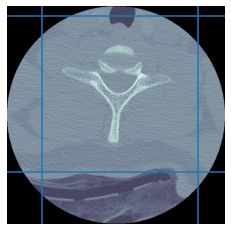

In [9]:
s = boundary_df.iloc[10]
print(s.name)
img = Image.open(os.path.join(DATA_DIR, 'train_axial_images_jpeg95', s.name, '247.jpeg'))
plt.axis('off')
plt.imshow(img, cmap='bone')
plt.axvline(s.xmin)
plt.axvline(s.xmax)
plt.axhline(s.ymin)
plt.axhline(s.ymax)

In [10]:
df = boundary_df[['aspect','xmin','ymin','xmax','ymax']]
df.to_csv(os.path.join(DATA_DIR, 'train_axial_boundary.csv'))

## axial bbox table

In [ ]:
# train_df = pd.read_csv(os.path.join(DATA_DIR, 'train_df_with_slices.csv')).set_index('StudyInstanceUID')
# train_df.head()

In [ ]:
# df = pd.DataFrame()
# for i in tqdm(range(len(boundary_df))):
#     s = boundary_df.iloc[i]
#     UID = s.name
#     num_slices = train_df.loc[UID, 'num_slices']
#     new_df = boundary_df.loc[[UID] * num_slices, ['xmin','ymin','xmax','ymax', 'aspect']]
#     new_df['axial_index'] = np.arange(num_slices)
#     df = pd.concat([df, new_df])
#
# print(len(df))
# df.tail()

In [ ]:
# df.to_csv(os.path.join(DATA_DIR, 'train_axial_boundary.csv'))